In [2]:
!pip install timm


pytorch_model.bin:   0%|          | 0.00/178M [00:00<?, ?B/s]

c:\Users\rebec\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rebec\.cache\huggingface\hub\models--timm--coat_lite_medium.in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Epoch 1/5 [Val]: 100%|██████████| 8/8 [00:27<00:00,  3.40s/it]


Epoch 1/5 - Train Loss: 217.1480, Train Acc: 79.51% - Val Loss: 1.5547, Val Acc: 96.40%


Epoch 2/5 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


Epoch 2/5 - Train Loss: 38.6086, Train Acc: 95.74% - Val Loss: 1.2815, Val Acc: 96.80%


Epoch 3/5 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.65s/it]


Epoch 3/5 - Train Loss: 23.4468, Train Acc: 97.40% - Val Loss: 1.1158, Val Acc: 96.80%


Epoch 4/5 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


Epoch 4/5 - Train Loss: 16.3239, Train Acc: 98.19% - Val Loss: 1.6221, Val Acc: 94.80%


Epoch 5/5 [Val]: 100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


Epoch 5/5 - Train Loss: 11.6749, Train Acc: 98.84% - Val Loss: 1.4762, Val Acc: 96.40%


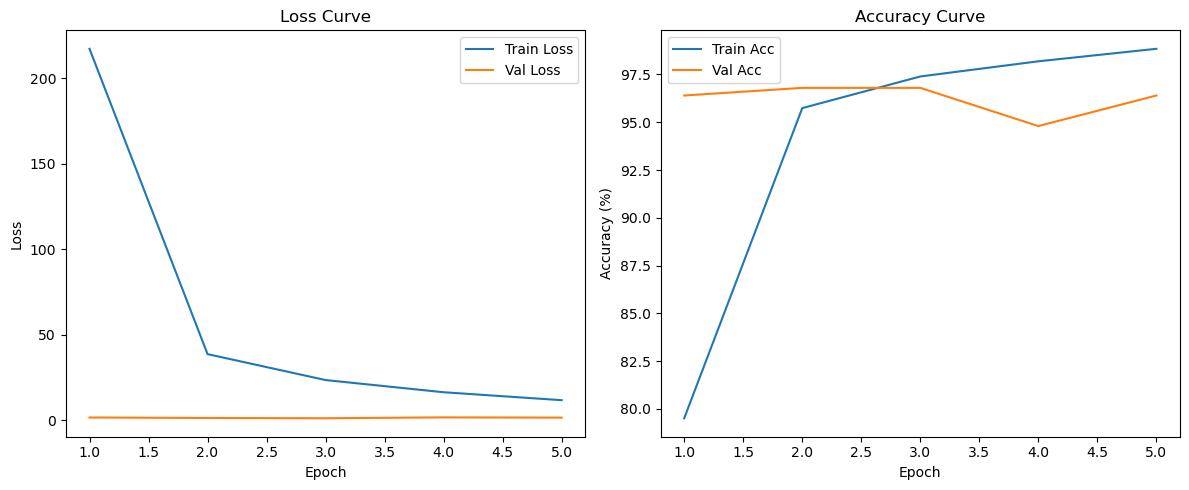

Test Accuracy (CoaT-Lite Medium + Partial FT + Reg): 98.40%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      0.80      0.89         5
  BIRD CHERRY ERMINE MOTH       0.83      1.00      0.91         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       0.83      1.00      0.91         5
       ELEPHANT HAWK MOTH       1.00      1.0

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
dataset_path = Path("../data/kaggle-dataset/archive")
train_path = dataset_path / "train"
val_path = dataset_path / "valid"
test_path = dataset_path / "test"

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and loaders
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

# Load CoaT-Lite Medium
model = create_model('coat_lite_medium', pretrained=True)

# Replace classifier
model.reset_classifier(num_classes)
model = model.to(device)

# Freeze all but last block
for name, param in model.named_parameters():
    if any([k in name for k in ["blocks.11", "norm", "head"]]):
        param.requires_grad = True
    else:
        param.requires_grad = False

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)

# Track history
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    train_losses.append(running_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Acc")
plt.plot(range(1, epochs + 1), val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Report
print("Test Accuracy (CoaT-Lite Medium + Partial FT + Reg): {:.2f}%".format(
    100 * np.mean(np.array(all_preds) == np.array(all_labels))
))
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Epoch 1/5: 100%|██████████| 225/225 [20:16<00:00,  5.41s/it]


Epoch 1: Train Acc: 79.90%, Val Acc: 97.20%


Epoch 2/5: 100%|██████████| 225/225 [20:38<00:00,  5.50s/it]


Epoch 2: Train Acc: 95.63%, Val Acc: 97.60%


Epoch 3/5: 100%|██████████| 225/225 [20:38<00:00,  5.50s/it]


Epoch 3: Train Acc: 97.51%, Val Acc: 96.80%


Epoch 4/5: 100%|██████████| 225/225 [20:40<00:00,  5.51s/it]


Epoch 4: Train Acc: 98.23%, Val Acc: 96.80%


Epoch 5/5: 100%|██████████| 225/225 [20:38<00:00,  5.50s/it]


Epoch 5: Train Acc: 98.77%, Val Acc: 96.40%


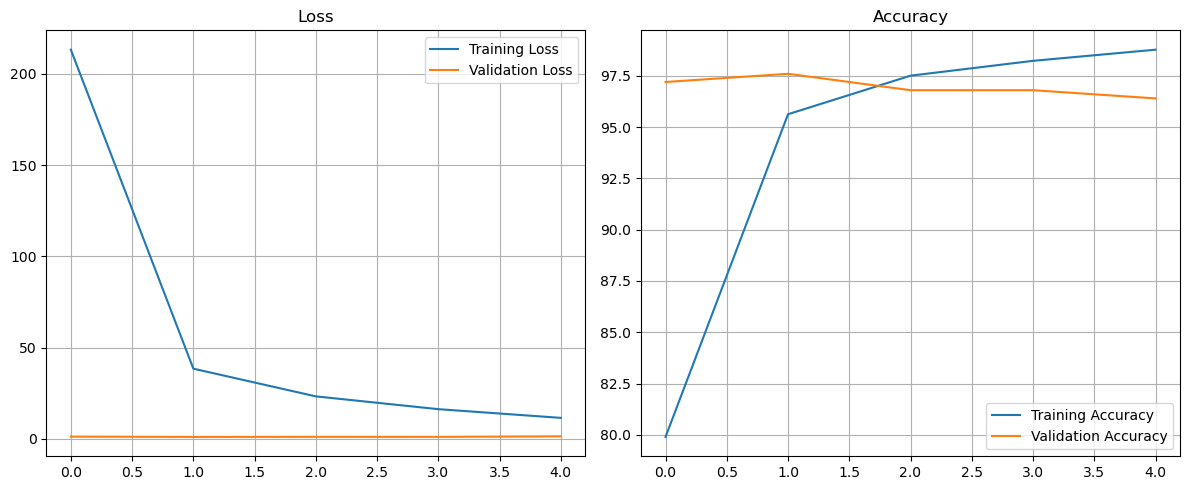

Test Accuracy: 98.80%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [1]:
# Import necessary libraries
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from timm import create_model

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/kaggle-dataset/archive")

# Transforms - standard normalization used for ImageNet pretrained weights
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup
data_transforms = {
    'train': transform,
    'valid': transform,
    'test': transform
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

dataloaders = {
    split: DataLoader(image_datasets[split], batch_size=32, shuffle=(split == 'train'), num_workers=4)
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Load CoaT-Lite Medium model with pretrained weights
model = create_model('coat_lite_medium', pretrained=True)

# Replace the final classification layer to match the number of different moth species
model.reset_classifier(num_classes)

# Freeze all layers, then unfreeze the last block and classifier to enable partial fine-tuning
for name, param in model.named_parameters():
    if any([k in name for k in ["blocks.11", "norm", "head"]]):
        param.requires_grad = True
    else:
        param.requires_grad = False

model.to(device)

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [2]:
# Visualise confused species pairs
def show_confused_species(dataset_dir, confused_pairs, n_samples=3):
    """
    This function will display sample images of species the model confused with one another side-by-side.
    """
    test_dir = Path(dataset_dir) / "test"

    for true_class, pred_class in confused_pairs:
        true_imgs = list((test_dir / true_class).glob("*"))
        pred_imgs = list((test_dir / pred_class).glob("*"))

        true_samples = random.sample(true_imgs, min(n_samples, len(true_imgs)))
        pred_samples = random.sample(pred_imgs, min(n_samples, len(pred_imgs)))

        print(f"\nConfused: '{true_class}' predicted as '{pred_class}'")

        fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 3, 5))

        for i in range(n_samples):
            # Actual species images
            if i < len(true_samples):
                axes[0, i].imshow(Image.open(true_samples[i]))
                axes[0, i].set_title(true_class, fontsize=9)
            axes[0, i].axis('off')

            # Predicted species images
            if i < len(pred_samples):
                axes[1, i].imshow(Image.open(pred_samples[i]))
                axes[1, i].set_title(pred_class, fontsize=9)
            axes[1, i].axis('off')

        plt.suptitle(f"'{true_class}' ↔ '{pred_class}'", fontsize=12)
        plt.tight_layout()
        plt.show()



Confused: 'CLEARWING MOTH' predicted as 'HUMMING BIRD HAWK MOTH'


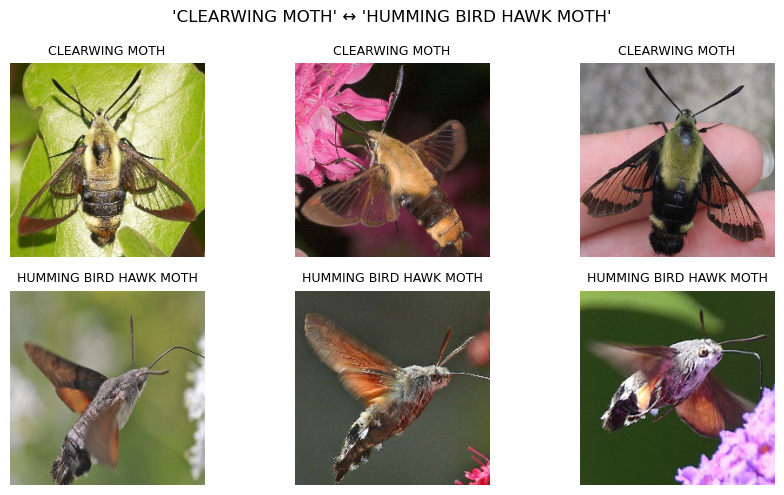


Confused: 'EMPEROR MOTH' predicted as 'EMPEROR GUM MOTH'


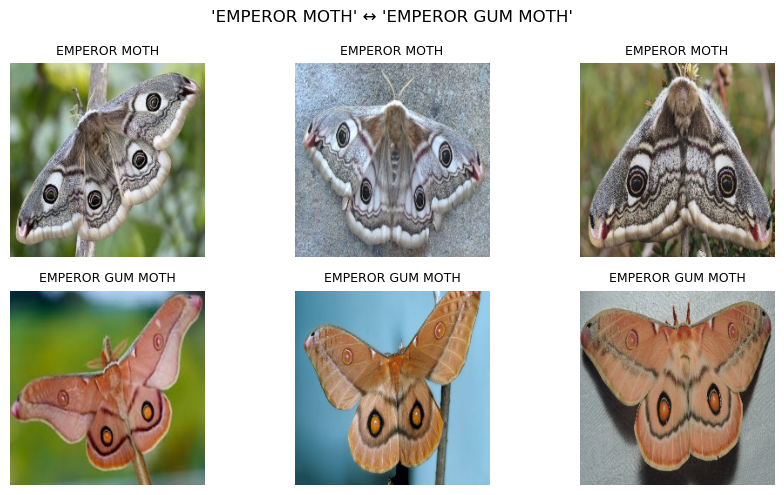

In [3]:
# Define confused class pairs based on the confusion matrix output
confused_pairs_to_plot = [
    ("CLEARWING MOTH", "HUMMING BIRD HAWK MOTH"),
    ("EMPEROR MOTH", "EMPEROR GUM MOTH")
]

# Call the visualisation function
show_confused_species("../data/kaggle-dataset/archive", confused_pairs_to_plot)